#Setup

In [1]:
use_gdrive = True # @param {type:"boolean"}

RESULTS_PATH = "results1"

if use_gdrive:
  try:
    # mount your google drive to get permanent storage for your results
    from google.colab import drive
    drive.mount('/content/drive')

    RESULTS_PATH = "/content/drive/MyDrive/infoseclab23/results1"
  except ModuleNotFoundError:
    print("failed to mount gdrive")
else:
  print(f"saving results to '{RESULTS_PATH}'. If you're using Google Colab, this folder will be deleted when you disconnect!")

!mkdir -p {RESULTS_PATH}

Mounted at /content/drive


In [2]:
import sys

# Lab files
![ ! -d 'infoseclab_23' ] && git clone https://github.com/ethz-spylab/infoseclab_23.git
%cd infoseclab_23
!git pull https://github.com/ethz-spylab/infoseclab_23.git
%cd ..
if "infoseclab_23" not in sys.path:
  sys.path.append("infoseclab_23")

Cloning into 'infoseclab_23'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 34 (delta 0), reused 2 (delta 0), pack-reused 30
Receiving objects: 100% (34/34), 268.09 MiB | 46.15 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (25/25), done.
/content/infoseclab_23
From https://github.com/ethz-spylab/infoseclab_23
 * branch            HEAD       -> FETCH_HEAD
Already up to date.
/content


#Imports

In [3]:
import torch
import numpy as np
import infoseclab
from infoseclab import defenses, ImageNet, EPSILON, utils, evaluation
import os
from zipfile import ZipFile

device = "cuda"

# 0.&nbsp; A quick primer on constrained optimization in PyTorch

To get a feel for how to optimize functions in PyTorch over a domain, below we solve a simple 1-dimensional function mimization problem.

We want to find the minimum of $f(x)$ under the constraint $x \in [-1, 1]$.

(the actual minimimum is at $x=\sqrt{2/3} \approx 0.8165$ and has value $f(x) \approx -6.089$).

In [4]:
# the function we want to minimize
def f(x):
  return x**3 - 2*x - 5

# our starting point
x = torch.zeros(1).to(device)

for i in range(20):
  x = x.requires_grad_(True)  # we want to take gradients with respect to x

  objective = f(x)            # compute the current objective
  objective.backward()        # take the gradient of the objective with respect to all inputs
  grad = x.grad.detach()      # get the value of the gradient with respect to x

  print(f"step {i}: f({x.item():.2f}) = {objective.item():.2f}")

  with torch.no_grad():
    x = x - 0.05 * torch.sign(grad)  # take a gradient update step to minimize the objective
    x = torch.clamp(x, -1, 1)        # ensure we stay in the allowed range

step 0: f(0.00) = -5.00
step 1: f(0.05) = -5.10
step 2: f(0.10) = -5.20
step 3: f(0.15) = -5.30
step 4: f(0.20) = -5.39
step 5: f(0.25) = -5.48
step 6: f(0.30) = -5.57
step 7: f(0.35) = -5.66
step 8: f(0.40) = -5.74
step 9: f(0.45) = -5.81
step 10: f(0.50) = -5.88
step 11: f(0.55) = -5.93
step 12: f(0.60) = -5.98
step 13: f(0.65) = -6.03
step 14: f(0.70) = -6.06
step 15: f(0.75) = -6.08
step 16: f(0.80) = -6.09
step 17: f(0.85) = -6.09
step 18: f(0.80) = -6.09
step 19: f(0.85) = -6.09


# 1.&nbsp;Targeted PGD attack on undefended ResNet-50

We will first run a simple *targeted* PGD attack, where the goal is to get the model to misclassify an input `(x, y)` into a specific incorrect class `y'`.

You can design your attack however you'd like, but we recommend first
implementing a `project` method that projects an adversarial example
onto the Lp ball centered at the original sample. It is customary to
also ensure that the projected sample is in the valid range for an image (i.e.,
all pixel values in [0, 255]).



In [5]:
class PGD(object):
    """
    A targeted PGD attack in l_inf norm.
    """
    def __init__(self, epsilon, clf):
        """
        :param epsilon: the maximum perturbation allowed
        :param clf: the classifier to attack
        """
        self.epsilon = epsilon
        self.clf = clf

    def project(self, x_adv, x_orig):
        """
        Project x_adv onto the epsilon ball around x_orig.
        :param x_adv: the adversarial images
        :param x_orig: the clean images
        :return: the adversarial images projected onto the epsilon ball, in the range [0, 255]
        """
        perturbation = x_adv - x_orig
        normalized_perturbation = torch.norm(perturbation.flatten(), float('inf'))
        ### normalization
        if normalized_perturbation > self.epsilon:
          scaling_factor = self.epsilon / normalized_perturbation
          perturbation = perturbation * scaling_factor

        x_adv_projected = torch.clamp(x_orig + perturbation, 0, 255)
        return x_adv_projected

    def attack_batch(self, x, y_targets):
        """
        Attack a batch of images with PGD.
        :param x: the batch of images (torch tensors) to attack of size (batch_size, 3, 224, 224)
        :param y_targets: the target labels of size (batch_size,)
        :return: the adversarial images of size (batch_size, 3, 224, 224)
        """
        num_iterations = 20
        step_size = 0.5

        ### make a copy
        x_adv = torch.clone(x)
        for _ in range(num_iterations):
          x_adv.requires_grad_(True)

          ### derive loss
          outputs = self.clf.get_logits(x_adv)
          loss = torch.nn.functional.cross_entropy(outputs, y_targets)

          ### back prop
          loss.backward()
          grad = x_adv.grad.detach()

          with torch.no_grad():
            ### take a gradient step
            x_adv = x_adv - step_size * torch.sign(grad)
            ### project within the epsilon ball
            x_adv = self.project(x_adv, x)

        ### return the adversarial image
        return x_adv.detach()

    def attack_all(self, images, labels, batch_size=20):
        """
        A utility to attack all images in the dataset by batching.
        :param images: the images to attack, of size (N, 3, 224, 224) in the range [0, 255]
        :param labels: the target labels
        :param batch_size: the batch size to use
        :return: the adversarial images
        """
        return utils.batched_func(self.attack_batch, inputs=(images, labels),
                                  batch_size=batch_size,
                                  device=self.clf.device)

# load the defense
resnet = defenses.ResNet(device)

pgd = PGD(epsilon=EPSILON, clf=resnet)
x_adv = pgd.attack_all(ImageNet.clean_images, ImageNet.targets, batch_size=6)

utils.save_images(os.path.join(RESULTS_PATH, "x_adv_targeted.npy"), x_adv)
evaluation.eval_targeted_pgd(os.path.join(RESULTS_PATH, "x_adv_targeted.npy"), device);

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]
100%|██████████| 34/34 [00:44<00:00,  1.31s/it]
/content/infoseclab_23/infoseclab/utils.py:47: UserWarning: Images are not the same after saving and loading.
  warnings.warn("Images are not the same after saving and loading.")


=== Evaluating targeted PGD ===
	clean accuracy: 100.0%
	adv accuracy: 0.0% (target: ≤ 2.0%)
	adv target accuracy: 100.0% (target: ≥98.0%)
SUCCESS


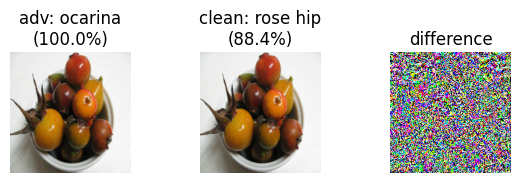

In [6]:
# you can visualize your attack samples as follows if this helps
idx = 0
input = torch.stack([x_adv[idx], ImageNet.clean_images[idx]]).to(device)
logits = resnet.get_logits(input)
utils.display(x_adv[idx], image_orig=ImageNet.clean_images[idx], logits=logits)

# 2.&nbsp;Evading Detection

It turns out that "naive" adversarial examples are very easy to *detect*.
So one could build a defense that aims to detect when an input has been perturbed, to reject it and raise an alarm.

Unfortunately, as we'll see such defenses are hard to make robust against an *adaptive* attacker that also optimizes over the detector.

You will now implement attacks against two detector defenses:

<ul>
  <li> 2.1. A detector using a standard neural network. </li>
  <li> 2.2. A Random Forest detector </li>
<ul>

In [7]:
# Your previous attack is likely easily detected
evaluation.eval_detector_attack(os.path.join(RESULTS_PATH, "x_adv_targeted.npy"), device=device);

=== Evaluating targeted PGD with Neural Network Detector ===
	clean accuracy: 100.0%
	adv accuracy: 0.0% (target: ≤ 2.0%)
	adv target accuracy: 100.0% (target: ≥98.0%)
	clean examples detected: 2.5% (target: ≤5.0%)
	adv examples detected: 88.0% (target: ≤1.0%)
NOT THERE YET!


## 2.1&nbsp;Evading A Neural Network Detector

We will first do a targeted attack against the `ResNetDetector` defense.
This defense takes the standard `ResNet` classifier from before, and adds an additional detector network.

The defense can be used for classification, in which case it outputs an array of scores for each of the 1000 classes, for each input:

```
resnet_det = ResNetDetector(device)
resnet_det.get_logits(x) -> [N, 1000]
```

To obtain a detector, we trained a *binary* classifier that takes in an input and outputs binary logits for the task of distinguishing clean images (class 0) from adversarially perturbed ones (class 1):

```
resnet_det = ResNetDetector(device)
resnet_det.get_detection_logits(x) -> [N, 2]
```

*(the classifier and detector actually share most of their implementation.
The original ResNet classifier is of the form `g(f(x))` where `f` is a <u>feature extractor</u> that maps inputs to feature vectors, and `g` is a <u>linear layer</u> that maps a feature vector to a vector of 1000 class scores.
The detector takes as input the same feature vector `f(x)`, and applies a different linear layer `g_det` that maps the features to a vector of 2 class scores.
See `infoseclab.defenses.defense_detector.ResNetDetector` for details).*

Note: You are allowed to use the `ResNetDetector` module in your attack, but you are not allowed to modify it.

In [9]:
class PGD_Det(PGD):
    """
    A targeted PGD attack that also tries to evade detection.
    """

    def __init__(self, epsilon, clf):
        """
        :param epsilon: the maximum perturbation allowed
        :param clf: the classifier to attack
        """
        super().__init__(epsilon, clf)

    def attack_batch(self, x, y_targets):
        """
        Attack a batch of images with targeted PGD while also evading detection.
        :param x: the batch of images (torch tensors) to attack of size (batch_size, 3, 224, 224)
        :param y_targets: the target labels of size (batch_size,)
        :return: the adversarial images of size (batch_size, 3, 224, 224)
        """
        num_iterations = 20
        step_size = 0.5

        ### to escape the detector
        y_anti_detector = torch.zeros_like(y_targets)

        ### make a copy
        x_adv = torch.clone(x)
        for _ in range(num_iterations):
          x_adv.requires_grad_(True)

          ##################### for misclassficiation ##############
          outputs = self.clf.get_logits(x_adv)
          loss = torch.nn.functional.cross_entropy(outputs, y_targets)
          loss.backward()

          ################### for escaping detector ###################
          outputs_detector = self.clf.get_detection_logits(x_adv)
          loss_detector = torch.nn.functional.cross_entropy(outputs_detector, y_anti_detector)
          loss_detector.backward()

          grad = x_adv.grad.detach()

          with torch.no_grad():
            ### take a gradient step
            x_adv = x_adv - step_size * torch.sign(grad)
            ### project within the epsilon ball
            x_adv = self.project(x_adv, x)

        ### return the adversarial image
        return x_adv.detach()

defense_det = defenses.ResNetDetector(device)
pgd_det = PGD_Det(epsilon=EPSILON, clf=defense_det)
x_adv_det = pgd_det.attack_all(ImageNet.clean_images, ImageNet.targets, batch_size=6)

utils.save_images(os.path.join(RESULTS_PATH, "x_adv_detect.npy"), x_adv_det)
evaluation.eval_detector_attack(os.path.join(RESULTS_PATH, "x_adv_detect.npy"), device=device);

100%|██████████| 34/34 [01:26<00:00,  2.54s/it]


=== Evaluating targeted PGD with Neural Network Detector ===
	clean accuracy: 100.0%
	adv accuracy: 0.0% (target: ≤ 2.0%)
	adv target accuracy: 100.0% (target: ≥98.0%)
	clean examples detected: 2.5% (target: ≤5.0%)
	adv examples detected: 0.0% (target: ≤1.0%)
SUCCESS


## 2.2&nbsp;Evading a Random Forest Detector

You will now try to attack a second detector defense.
As with the previous defense, we first classify the input in a standard way using the ResNet50 model.

But this time, the detector is an opaque "Random Forest" model that takes as
input the features from the resnet model and outputs a decision.
This is a discrete model (a Random Forest is a collection of decision trees) that cannot be easily differentiated. So you'll need
a new strategy!

**For this defense, your attack can be untargeted. That is, it suffices that the adversarial examples are classified into <i>any</i> incorrect class, as long as the detector doesn't flag the sample.**

In [10]:
class PGD_Det_RF(PGD):
    """
    A targeted PGD attack that also tries to evade detection with a random forest.
    """

    def __init__(self, epsilon, clf):
        """
        :param epsilon: the maximum perturbation allowed
        :param clf: the classifier to attack
        """
        super().__init__(epsilon, clf)

    def attack_batch(self, x, y):
        """
        Attack a batch of images with targeted PGD while also evading detection.
        :param x: the batch of images (torch tensors) to attack of size (batch_size, 3, 224, 224)
        :param y: the labels of size (batch_size,)
        :return: the adversarial images of size (batch_size, 3, 224, 224)
        """
        num_iterations = 20
        step_size = 0.5

        ### make a copy
        x_adv = torch.clone(x)
        for _ in range(num_iterations):
          x_adv.requires_grad_(True)

          ##################### for misclassficiation ##############
          outputs = self.clf.get_logits(x_adv)
          loss = (-1) * torch.nn.functional.cross_entropy(outputs, y)
          loss.backward()

          grad = x_adv.grad.detach()

          with torch.no_grad():
            ### save a copy
            x_adv_previous = torch.clone(x_adv)

            ### take a gradient step and project back to the epsilon ball
            x_adv = x_adv - step_size * torch.sign(grad)
            x_adv = self.project(x_adv, x)

            ### for detected examples, go back to the previous version
            x_adv_detected_mask = self.are_we_detected(x_adv)
            x_adv[x_adv_detected_mask] = x_adv_previous[x_adv_detected_mask]

        ### return the adversarial image
        return x_adv.detach()

    def are_we_detected(self, x_adv):
        """
        Check whether we are detected
        :param x_adv: the adversarial images
        :return: a boolean tensor indicating whether the detector flags each input
        """
        decision = self.clf.detect(x_adv)
        return decision == 1


defense_det_rf = defenses.RFDetector(device)
pgd_det_rf = PGD_Det_RF(epsilon=EPSILON, clf=defense_det_rf)
x_adv_det_rf = pgd_det_rf.attack_all(ImageNet.clean_images, ImageNet.labels, batch_size=6)

utils.save_images(os.path.join(RESULTS_PATH, "x_adv_detect_rf.npy"), x_adv_det_rf)
evaluation.eval_rf_detector_attack(os.path.join(RESULTS_PATH, "x_adv_detect_rf.npy"), device=device);

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
100%|██████████| 34/34 [00:59<00:00,  1.74s/it]
/content/infoseclab_23/infoseclab/utils.py:47: UserWarning: Images are not the same after saving and loading.
  warnings.warn("Images are not the same after saving and loading.")


=== Evaluating untargeted PGD with Random Forest Detector ===


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


	clean accuracy: 100.0%
	adv accuracy: 0.5% (target: ≤ 2.0%)
	clean examples detected: 0.0% (target: ≤5.0%)
	adv examples detected: 0.5% (target: ≤1.0%)
SUCCESS


#3.&nbsp; Preprocessing Defenses

We are now going to look at two defenses against adversarial examples that aim to resist noise by *pre-processing* the input before classifying it.

<ul>
  <li> 3.1. Blurring </li>
  <li> 3.2. Random cropping and noising </li>
  <li> 3.3. Input discretization </li>
<ul>

##3.1&nbsp; Blurring

A natural defense idea is to try and remove the noise from adversarial images. A simple way of trying to do that is to add a blurring filter.

The `ResNetBlur` defense implements this. Your goal is to create a targeted PGD attack that will defeat Blurring.
You **don't** need to ensure that the attack stays undetected.

The challenge you'll encounter is that the Blurring filter we use is not automatically differentiable. You'll likely need to find a way around that!

In [11]:
class PGD_Blur(PGD):
    """
    A targeted PGD attack that tries to resist Blurring.
    """

    def __init__(self, epsilon, clf):
        """
        :param epsilon: the maximum perturbation allowed
        :param clf: the classifier to attack
        """
        super().__init__(epsilon, clf)

    def attack_batch(self, x, y_targets):
        """
        Attack a batch of images with targeted PGD while also resisting JPEG compression.
        :param x: the batch of images (torch tensors) to attack of size (batch_size, 3, 224, 224)
        :param y_targets: the target labels of size (batch_size,)
        :return: the adversarial images of size (batch_size, 3, 224, 224)
        """

        num_iterations = 20
        step_size = 0.5

        ### make a copy
        x_adv = torch.clone(x)
        for _ in range(num_iterations):
          ### approximate ∇xf(g(x)) by evaluating ∇xf(x) at the point g(x)
          ### using the blurred image as input
          x_adv_blurred = defenses.defense_blur.blur_images(x_adv)
          x_adv_blurred.requires_grad_(True)
          ### call the original classifier
          model_output = super(type(defense_blur), self.clf).get_logits(x_adv_blurred)
          loss = torch.nn.functional.cross_entropy(model_output, y_targets)

          loss.backward()
          grad = x_adv_blurred.grad.detach()

          with torch.no_grad():
            ### take a gradient step
            x_adv = x_adv - step_size * torch.sign(grad)
            ### project within the epsilon ball
            x_adv = self.project(x_adv, x)

        ### return the adversarial image
        return x_adv.detach()


defense_blur = defenses.ResNetBlur(device)
pgd_blur = PGD_Blur(epsilon=EPSILON, clf=defense_blur)
x_adv_blur = pgd_blur.attack_all(ImageNet.clean_images, ImageNet.targets, batch_size=6)

utils.save_images(os.path.join(RESULTS_PATH, "x_adv_blur.npy"), x_adv_blur)
evaluation.eval_blur_attack(os.path.join(RESULTS_PATH, "x_adv_blur.npy"), device);

100%|██████████| 34/34 [01:51<00:00,  3.28s/it]
/content/infoseclab_23/infoseclab/utils.py:47: UserWarning: Images are not the same after saving and loading.
  warnings.warn("Images are not the same after saving and loading.")


=== Evaluating targeted PGD on blurred defense ===
	clean accuracy: 92.5%
	adv accuracy: 0.0% (target: ≤ 2.0%)
	adv target accuracy: 100.0% (target: ≥98.0%)
SUCCESS


##3.2&nbsp; Randomized cropping and noising

Another natural defense idea is to try and *randomize* the model's behavior to make it harder to create adversarial examples.

The ResNetRandom defense implements this, by randomly cropping and noising input images before classifying them.

Your goal is to create a targeted PGD attack that will defeat randomized pre-processing.
In this part, you **don't** need to ensure that the attack stays undetected.

**Note that since this defense is randomized, the evaluation results might vary slightly from one run to the next. To make sure that your attack passes our final evaluation, try to create an attack that has a few % of slack compared to the evaluation targets (e.g., if we target an adversarial accuracy below 5%, aim to ensure that your attack reaches ~3% or lower)**

In [ ]:
class PGD_Random(PGD):
    """
    A PGD attack that also tries to resist random preprocessing.
    """

    def __init__(self, epsilon, clf):
        super().__init__(epsilon, clf)

    def attack_batch(self, x, y_targets):
        """
        Attack a batch of images with targeted PGD while also evading random preprocessing.
        :param x: the batch of images (torch tensors) to attack of size (batch_size, 3, 224, 224)
        :param y_targets: the target labels of size (batch_size,)
        :return: the adversarial images of size (batch_size, 3, 224, 224)
        """
        num_iterations = 30
        step_size = 1
        nr_of_samples_per_iteration = 14

        ### make a copy
        x_adv = torch.clone(x)
        for _ in range(num_iterations):
          x_adv.requires_grad_(True)
          loss = 0
          ### multiple rounds to balance off the randomness
          for _ in range(nr_of_samples_per_iteration):
            outputs = self.clf.get_logits(x_adv)
            loss += torch.nn.functional.cross_entropy(outputs, y_targets)
          loss /= nr_of_samples_per_iteration

          ### back prop
          loss.backward()
          grad = x_adv.grad.detach()

          with torch.no_grad():
            ### take a gradient step
            x_adv = x_adv - step_size * torch.sign(grad)
            ### project within the epsilon ball
            x_adv = self.project(x_adv, x)

        ### return the adversarial image
        return x_adv.detach()


defense_random = defenses.ResNetRandom(device)
pgd_random = PGD_Random(epsilon=EPSILON, clf=defense_random)
x_adv_random = pgd_random.attack_all(ImageNet.clean_images, ImageNet.targets, batch_size=6)

utils.save_images(os.path.join(RESULTS_PATH, "x_adv_random.npy"), x_adv_random)
evaluation.eval_random_attack(os.path.join(RESULTS_PATH, "x_adv_random.npy"), device);

100%|██████████| 34/34 [15:34<00:00, 27.48s/it]


=== Evaluating targeted PGD on randomized defense ===
	clean accuracy: 92.5%
	adv accuracy: 0.5% (target: ≤ 2.0%)
	adv target accuracy: 98.5% (target: ≥98.0%)
SUCCESS


##3.3&nbsp; Discretized inputs

This final defense does something a bit crazy to make it hard for you to compute gradients (a lot of proposed defenses against adversarial examples used to do this, but none of them work...)

This defense discretizes the model's inputs as follows: each pixel (in the range [0, 1]) is mapped to an array of 20 binary "buckets", where the i-th bucket is set if the input pixel is greater than i/20. So for example we encode `0.0` as `[0 0 0 0 0 ... 0]`, `0.1` as `[1 1 0 0 ... 0]` and `1.0` as `[1 1 1 1 1 ... 1]`.

See the `ResNetDiscrete` defense for the implementation of this encoding.

The encoded inputs are then fed into a ResNet-style model (which was modified to take in inputs with `3*20` pixel channels instead of `3`).

Your goal is to create targeted adversarial examples that break this defense.

In [12]:
class PGD_Discrete(PGD):
    """
    A PGD attack that also tries to resist input discretization.
    """

    def __init__(self, epsilon, clf):
        super().__init__(epsilon, clf)

    def attack_batch(self, x, y_targets):
        """
        Attack a batch of images with targeted PGD while also evading random preprocessing.
        :param x: the batch of images (torch tensors) to attack of size (batch_size, 3, 224, 224)
        :param y_targets: the target labels of size (batch_size,)
        :return: the adversarial images of size (batch_size, 3, 224, 224)
        """
        num_iterations = 20
        step_size = 0.5

        ### make a copy
        x_adv = torch.clone(x)
        for _ in range(num_iterations):
          x_adv_discretized = self.clf.encode(x_adv / 255.0)
          x_adv_discretized.requires_grad_(True)

          ### derive loss
          outputs = self.clf.model(x_adv_discretized)
          loss = torch.nn.functional.cross_entropy(outputs, y_targets)

          ### back prop
          loss.backward()
          grad = x_adv_discretized.grad.detach()

          with torch.no_grad():
            ### take a gradient step (decode the gradient first)
            grad = self.decode(grad)
            x_adv = x_adv - step_size * torch.sign(grad)
            ### project within the epsilon ball
            x_adv = self.project(x_adv, x)

        ### return the adversarial image
        return x_adv.detach()

    ### the exact reverse process of encode
    def decode(self, x):
        # discretize into 20 bins
        thresholds = torch.from_numpy(np.arange(0, 1, .05)).to(x.device).float()
        # average
        thresholds += 0.025

        x = x.permute(0, 2, 3, 1)
        shape = list(x.shape)  ### x is now of shape [1, 224, 224, 60]


        shape[-1] = shape[-1] // thresholds.shape[0]
        shape.append(thresholds.shape[0])

        x = x.reshape(shape) ### x is now of shape [1, 224, 224, 3, 20]
        x = x * thresholds  ### x is now of shape [1, 224, 224, 3]

        x = torch.max(x, dim = -1).values ### let's go back to where we were
        x = x.permute(0, 3, 1, 2)

        return x


defense = defenses.ResNetDiscrete(device)
pgd_discrete = PGD_Discrete(epsilon=EPSILON, clf=defense)
x_adv_discrete = pgd_discrete.attack_all(ImageNet.clean_images, ImageNet.targets, batch_size=6)

utils.save_images(os.path.join(RESULTS_PATH, "x_adv_discrete.npy"), x_adv_discrete)
evaluation.eval_discrete_attack(os.path.join(RESULTS_PATH, "x_adv_discrete.npy"), device);

100%|██████████| 34/34 [00:40<00:00,  1.20s/it]


=== Evaluating targeted PGD on discretized defense ===
	clean accuracy: 80.5%
	adv accuracy: 0.0% (target: ≤ 3.0%)
	adv target accuracy: 100.0% (target: ≥96.0%)
SUCCESS


# Create submission file (**upload `results1.zip` to moodle**)

In [13]:
!zip -j -FSr "{RESULTS_PATH}/results1.zip" {RESULTS_PATH}

updating: x_adv_detect.npy (deflated 14%)
updating: x_adv_detect_rf.npy (deflated 24%)
updating: x_adv_targeted.npy (deflated 14%)
updating: x_adv_blur.npy (deflated 13%)
updating: x_adv_random.npy (deflated 13%)
updating: x_adv_discrete.npy (deflated 13%)


In [14]:
from infoseclab.evaluation import eval_targeted_pgd, eval_detector_attack, eval_rf_detector_attack, eval_blur_attack, eval_random_attack, eval_discrete_attack
from infoseclab.submission import validate_zip1

assert validate_zip1(f"{RESULTS_PATH}/results1.zip")

with ZipFile(f"{RESULTS_PATH}/results1.zip", 'r') as zip:
    _ = eval_targeted_pgd(path=zip.open("x_adv_targeted.npy"), device=device)
    _ = eval_detector_attack(path=zip.open("x_adv_detect.npy"), device=device)
    _ = eval_rf_detector_attack(path=zip.open("x_adv_detect_rf.npy"), device=device)
    _ = eval_blur_attack(path=zip.open("x_adv_blur.npy"), device=device)
    _ = eval_random_attack(path=zip.open("x_adv_random.npy"), device=device)
    _ = eval_discrete_attack(path=zip.open("x_adv_discrete.npy"), device=device)

Zip file is valid
=== Evaluating targeted PGD ===
	clean accuracy: 100.0%
	adv accuracy: 0.0% (target: ≤ 2.0%)
	adv target accuracy: 100.0% (target: ≥98.0%)
SUCCESS
=== Evaluating targeted PGD with Neural Network Detector ===
	clean accuracy: 100.0%
	adv accuracy: 0.0% (target: ≤ 2.0%)
	adv target accuracy: 100.0% (target: ≥98.0%)
	clean examples detected: 2.5% (target: ≤5.0%)
	adv examples detected: 0.0% (target: ≤1.0%)
SUCCESS
=== Evaluating untargeted PGD with Random Forest Detector ===


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


	clean accuracy: 100.0%
	adv accuracy: 0.5% (target: ≤ 2.0%)
	clean examples detected: 0.0% (target: ≤5.0%)
	adv examples detected: 0.5% (target: ≤1.0%)
SUCCESS
=== Evaluating targeted PGD on blurred defense ===
	clean accuracy: 92.5%
	adv accuracy: 0.0% (target: ≤ 2.0%)
	adv target accuracy: 100.0% (target: ≥98.0%)
SUCCESS
=== Evaluating targeted PGD on randomized defense ===
	clean accuracy: 93.5%
	adv accuracy: 1.0% (target: ≤ 2.0%)
	adv target accuracy: 99.0% (target: ≥98.0%)
SUCCESS
=== Evaluating targeted PGD on discretized defense ===
	clean accuracy: 80.5%
	adv accuracy: 0.0% (target: ≤ 3.0%)
	adv target accuracy: 100.0% (target: ≥96.0%)
SUCCESS
